<a href="https://colab.research.google.com/github/charlesincharge/Caltech-CS155-2022/blob/main/sets/set4/set4_prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2 Sample Code

This sample code is meant as a guide on how to use PyTorch and how to use the relevant model layers. This not a guide on how to design a network and the network in this example is intentionally designed to have poor performace.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [2]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [15]:
print(len(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))
print(train_dataset[5][0].shape)

60000 <class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])


Problem B: The Data

In [18]:
# What are the height and width of the images?
print("Height: ", train_dataset[0][0].shape[1])
print("Width: ", train_dataset[0][0].shape[2])
print("Number of training images: ", len(train_dataset))
print("Number of testing images: ", len(test_dataset))
print("Num pixels", 28*28)

Height:  28
Width:  28
Number of training images:  60000
Number of testing images:  10000
Num pixels 784


We can convert images to numpy arrays and plot them with matplotlib:

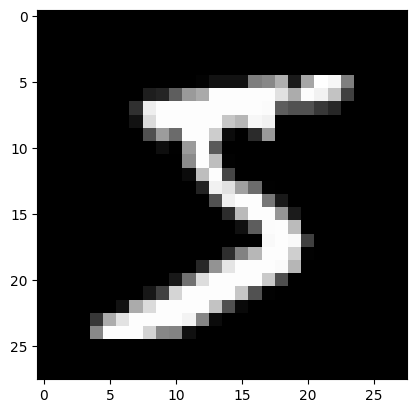

In [4]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Network Definition
Let's instantiate a model and take a look at the layers.

In [304]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    # nn.Linear(80, 20),
    # nn.ReLU(),
    # nn.Dropout(0.15),
    nn.Linear(100, 10),
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)


## Training
We also choose an optimizer and a loss function.

In [305]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

We could write our training procedure manually and directly index the `Dataset` objects, but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:

In [306]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True) 

We now write our backpropagation loop, training for 10 epochs.

In [307]:
# Some layers, such as Dropout, behave differently during training
n_epochs = 15
epochs = range(0, n_epochs)
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
    # Putting layers like Dropout into evaluation mode
    model.eval()

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
        (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_losses.append(test_loss)
    train_loss = 0
    correct = 0
    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in train_loader:
            output = model(data)
            train_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    print('train set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
        (train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

Train Epoch: 1  Loss: 0.3118
Test set: Average loss: 0.0031, Accuracy: 9406/10000 (94.0600)
train set: Average loss: 0.0031, Accuracy: 56635/60000 (94.3917)
Train Epoch: 2  Loss: 0.0366
Test set: Average loss: 0.0022, Accuracy: 9592/10000 (95.9200)
train set: Average loss: 0.0020, Accuracy: 57804/60000 (96.3400)
Train Epoch: 3  Loss: 0.0181
Test set: Average loss: 0.0018, Accuracy: 9662/10000 (96.6200)
train set: Average loss: 0.0015, Accuracy: 58323/60000 (97.2050)
Train Epoch: 4  Loss: 0.0144
Test set: Average loss: 0.0017, Accuracy: 9687/10000 (96.8700)
train set: Average loss: 0.0013, Accuracy: 58612/60000 (97.6867)
Train Epoch: 5  Loss: 0.1360
Test set: Average loss: 0.0014, Accuracy: 9724/10000 (97.2400)
train set: Average loss: 0.0010, Accuracy: 58910/60000 (98.1833)
Train Epoch: 6  Loss: 0.1280
Test set: Average loss: 0.0014, Accuracy: 9707/10000 (97.0700)
train set: Average loss: 0.0009, Accuracy: 59010/60000 (98.3500)
Train Epoch: 7  Loss: 0.2441
Test set: Average loss: 0.001

## Testing
We can perform forward passes through the network without saving gradients.

In [310]:
# plt.plot(epochs, test_losses, label="test loss")
# plt.plot(epochs, train_losses, label="train loss")
# plt.legend()
# plt.xlabel("num epochs")
# plt.ylabel("Loss")
# model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
    (test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loss = 0
correct = 0
# Turning off automatic differentiation
with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        train_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

train_loss /= len(train_loader.dataset)
print('train set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
    (train_loss, correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset)))



Test set: Average loss: 0.0011, Accuracy: 9783/10000 (97.8300)
train set: Average loss: 0.0002, Accuracy: 59788/60000 (99.6467)


## Problem D: Modeling Part 2
Use at most 200 hidden units and build a model with at least 2 hidden layers to achieve at least 0.98% accuracy.

## Network Definition

In [350]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 190),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(190, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)

## Training

In [351]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True) 

In [353]:
n_epochs = 12

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        # optimize gradients
        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # calculate loss
        loss = loss_fn(output, target)

        # backward pass 
        loss.backward()

        # gradient descent
        optimizer.step()
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.1409
Train Epoch: 2  Loss: 0.1056
Train Epoch: 3  Loss: 0.3848
Train Epoch: 4  Loss: 0.0174
Train Epoch: 5  Loss: 0.0333
Train Epoch: 6  Loss: 0.1100
Train Epoch: 7  Loss: 0.1542
Train Epoch: 8  Loss: 0.0053
Train Epoch: 9  Loss: 0.0815
Train Epoch: 10  Loss: 0.0297
Train Epoch: 11  Loss: 0.0160
Train Epoch: 12  Loss: 0.0097


In [354]:
model.eval()
train_loss = 0
correct = 0 

for data, target in train_loader:
    output = model(data)
    loss = loss_fn(output, target)
    train_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item() 

print('Train set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
    (train_loss, correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset)))
    
test_loss = 0
correct = 0 

for data, target in test_loader:
    output = model(data)
    loss = loss_fn(output, target)
    test_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item() 

print('test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
    (test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Train set: Average loss: 13.4426, Accuracy: 59756/60000 (99.5933)
test set: Average loss: 11.2547, Accuracy: 9800/10000 (98.0000)


## Problem E: Modeling Part 3

Use 1000 hidden units and at least 3 hidden layers to get accuracy of at least 0.983

In [416]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

In [417]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=72, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=72, shuffle=True) 

In [418]:
train_losses = []
test_losses = []

n_epochs = 22
for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # zero grad
        optimizer.zero_grad()

        #forward pass 
        output = model(data)

        # loss
        loss = loss_fn(output, target)

        #backward pass
        loss.backward()

        # step 
        optimizer.step()
    model.eval()


    # Turning off automatic differentiation
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
            (test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        test_losses.append(test_loss)
        train_loss = 0
        correct = 0
    # Turning off automatic differentiation

        for data, target in train_loader:
            output = model(data)
            train_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        print('train set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
            (train_loss, correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))


Test set: Average loss: 0.0016, Accuracy: 9638/10000 (96.3800)
train set: Average loss: 0.0014, Accuracy: 58204/60000 (97.0067)
Train Epoch: 1  Loss: 0.0801
Test set: Average loss: 0.0011, Accuracy: 9761/10000 (97.6100)
train set: Average loss: 0.0008, Accuracy: 58929/60000 (98.2150)
Train Epoch: 2  Loss: 0.0249
Test set: Average loss: 0.0013, Accuracy: 9723/10000 (97.2300)
train set: Average loss: 0.0008, Accuracy: 58967/60000 (98.2783)
Train Epoch: 3  Loss: 0.0579
Test set: Average loss: 0.0011, Accuracy: 9779/10000 (97.7900)
train set: Average loss: 0.0004, Accuracy: 59413/60000 (99.0217)
Train Epoch: 4  Loss: 0.0257
Test set: Average loss: 0.0010, Accuracy: 9800/10000 (98.0000)
train set: Average loss: 0.0004, Accuracy: 59417/60000 (99.0283)
Train Epoch: 5  Loss: 0.1275
Test set: Average loss: 0.0010, Accuracy: 9800/10000 (98.0000)
train set: Average loss: 0.0004, Accuracy: 59508/60000 (99.1800)
Train Epoch: 6  Loss: 0.0077
Test set: Average loss: 0.0009, Accuracy: 9823/10000 (98.2

train set: Average loss: 3.4951, Accuracy: 59921/60000 (99.8683)
test set: Average loss: 12.9188, Accuracy: 9834/10000 (98.3400)


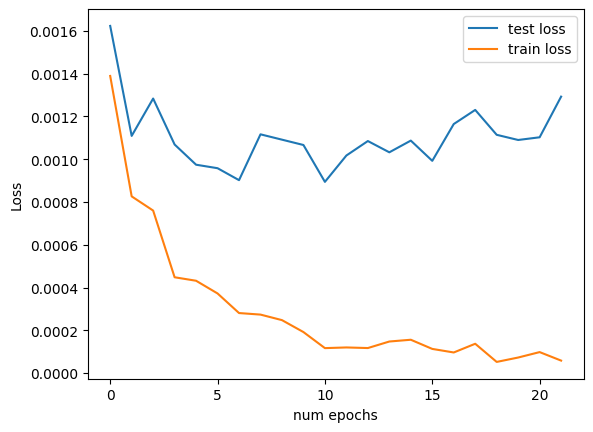

In [419]:
epochs = range(n_epochs)
# Evaluate
plt.plot(epochs, test_losses, label="test loss")
plt.plot(epochs, train_losses, label="train loss")
plt.legend()
plt.xlabel("num epochs")
plt.ylabel("Loss")
train_loss = 0
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        train_loss += loss_fn(output, target).item()
        pred = output.argmax(dim = 1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() 
    
    print('train set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
    (train_loss, correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset))) 

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.argmax(dim = 1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() 
    
    print('test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
    (test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset))) 